# Frames of Reference
## Coordinate Time
The time as observed by the coordinate frame itself. This is a "god's-eye view" of the time in the system we are analyzing. Basically, it represents a perfect clock held by the world/universe/simulation coordinate frame's observer. Usually Earth-centric systems use UTC or TAI as the Coordinate Time.

Formally, the coordinate time is the time that would be read on a hypothetical "coordinate clock" situated infinitely far from all gravitational masses, and stationary in the system of coordinates.
## Proper Time
The time as observed by a perfect clock attached to an object's local body frame. The body frame is a coordinate frame rigidly attached to the object. Whenever the object observes the time, it observes the local Proper Time.

In most situations, Proper Time and Coordinate Time are the same. The distinction between Proper Time and Coordinate Time is only relevant when objects are subjected to large accelerations or move across lumpy spacetime (like going from sea-level on Earth to standing on the Moon), and the effects of General Relativity become significant.

## System Time
So far we've only talked about the hypothetical, perfect clocks that describe the physics. But we actually want to observe these times ourselves with real clocks. Unfortunately, no clock is perfect or ideal. The _System Time_ is the real clock's observation of the local Proper Time. We'll explore System Time later when we learn more about [Allan Variance](https://en.wikipedia.org/wiki/Allan_variance).

# Time Dilation and Relativity
Let's apply our knowledge of Special Relativity (SR) and General Relativity (GR) to predict the phenomenon of time dilation.

**Special Relativity** describes spacetime far from a significant gravity field, and explains how a stationary observer perceives time passing slower for a moving observer when the relative velocity between them is very large.

**General Relativity** deals with gravity, and explains how time slows down in proximity to a large gravitational acceleration.

The [wikipedia page for time dilation](https://en.wikipedia.org/wiki/Time_dilation) provides a derivation of these effects and a handy plot showing time dilation in Earth orbit. Let's try to recreate it.

![time dilation plot](./Time_Dilation_vs_Orbital_Height.png)

We can see there are two terms here, one that only depends on potential, and one that depends on the velocity.

The kinematic term (red) is negative---it is working to "slow down" the proper time with respect to coordinate time by reducing the proper time's instant as velocity increases. Here, we're choosing the velocity required for a circular Earth orbit at each altitude. This is special relativity at work.

The potential, or gravitational, term (blue) is positive---it is working to "speed up" the proper time with respect to coordinate time by enlarging the proper time's instant as it leaves the gravity well. To be precise, a clock is slower for observers closer to the center of the gravity well. This is general relativity at work.

## Kinematic Dilation (Special Relativity)
Special Relativity states that the speed of light, $c$, is constant in all inertial reference frames. This leads to interesting consequences for spacetime.

Consider a coordinate frame with a space axis, $x$, and a time axis, $t$. For now let's assume that this coordinate frame is far from any gravity wells (we'll consider that later). Events are points in this coordinate frame with a time coordinate and a space coordinate. The length of a vector in this coordinate system, or the _spacetime interval_ between two events, represents the proper time measured with an inertial clock between the events.

Unlike linear spatial coordinates where the "grid" is square, spacetime coordinates are non-Euclidean, or not . The "grid" on the spacetime plot is made up of **hyperbolas** rather than lines. (Another example of non-Euclidean coordinates is spherical geometry, like latitude and longitude.)

The _Metric Equation_ describes this hyperbolic coordinate frame and lets us find a spacetime interval between events. ([Derivation](https://physics.unm.edu/Courses/Fields/Phys2310/Lectures/lecture27.pdf))
$$\Delta s^2 = \Delta t^2 - \Delta x^2$$

![spacetime is hyperbolic](./Spacetime_is_hyperbolic.png)

Let's rewrite the equation to be consistent with the variable names we've been using.
$$\Delta t_p^2 = \Delta t_c^2 - \Delta x^2$$

- $\Delta x$ is the distance traversed by a local observer of the event $e$ at some coordinate $(x,t)$.
- $\Delta t_c$ is the elapsed coordinate time to event $e$.
- $v = \Delta x / \Delta t_c$ is the speed of the moving observer relative to the coordinate frame.
- $\Delta t_p$, the length of a vector from the origin to $e$, is equal to the elapsed proper time according a local observer's inertial clock. This is also called the _spacetime interval_.

We want to relate the elapsed proper time $\Delta t_o$ to the elapsed coordinate time $\Delta t_c$. Special Relativity tells us that the speed of light, $c$, is constant in all inertial frames—this is the key to our solution. 

If we substitute our terms with equivalent definitions related to a pulse of light moving at $c$, we get
$$
\Big(c \frac{\Delta t_p}{2}\Big)^2 = \Big(c \frac{\Delta t_c}{2} \Big)^2 - \Big(v \frac{\Delta t_c}{2} \Big)^2, \quad v = \frac {\Delta x} {\Delta t_c}
$$
Solve for elapsed coordinate time using the locally observed proper time $\Delta t_o$ and the observer's speed in the coordinate frame. The relationship between proper time $t_o$ and coordinate time $t_c$ for special relativity depends only the relative speed between observers as the _Relativistic Factor_, $\gamma$, sometimes called the _Lorentz Factor_. Note that dilation from relative motion depends only on _relative speed between observers_ ($v$)---the acceleration of either observer has no bearing on kinematic dilation from special relativity.
$$
\gamma = \frac{\Delta t_c}{\Delta t_p} = \frac {1}{\sqrt{1 - v^2/c^2}}, \quad v = \frac {\Delta x} {\Delta t_c}
$$

There's a paradox here, did you catch it? Hint: _symmetry_ -> _reciprocity_ -> `spider_man_pointing.jpg`

> Given a certain frame of reference, and the "stationary" observer described earlier, if a second observer accompanied the "moving" clock, each of the observers would perceive the other's clock as ticking at a slower rate than their own local clock, due to them both perceiving the other to be the one that is in motion relative to their own stationary frame of reference.
>
> Common sense would dictate that, if the passage of time has slowed for a moving object, said object would observe the external world's time to be correspondingly sped up. Counterintuitively, special relativity predicts the opposite. When two observers are in motion relative to each other, each will measure the other's clock slowing down, in concordance with them being in motion relative to the observer's frame of reference. 

In the end this is a matter of perspective. So long as we are consistent and careful when comparing inertial frames, everything will be alright. 😌

We're not quite done: want to define "dilation" as _elapsed proper time per elapsed coordinate time_, or $\frac{\text{d}t_p}{\text{d}t_c}$. Let's reorganize the equation for convenience. 
$$
\frac{\text{d}t_p}{\text{d}t_c} = \sqrt{1 - v^2/c^2},\quad v = \frac {\text{d} x} {\text{d} t_c}
$$

Let's test this against our intiuitions.

$$\lim_{v \rightarrow c} \frac{\text{d}t_p}{\text{d}t_c} = \sqrt{1 - \frac{v^2}{c^2}} = \sqrt{1-1} = 0$$

So when $v_e = c$, our proper time stops:
$$\Delta t_p = (0) \Delta t_c = 0$$
Aha, so this is why why $c$ is the universe's "speed limit"--$v$ is $\Delta x / \Delta t_p$, but $\lim_{v \rightarrow c} \Delta t_p = 0$. We can't divide by zero, so $v$ cannot be greater than or equal to $c$! ✅

## Gravitational Dilation (General Relativity)
General Relativity states that massive objects warp spacetime around them, and the intensity of gravitational potential obeys the inverse square law. 

$$g = \frac{-G M_\oplus m}{r}$$

where:
* $g$ is the acceleration due to gravity,
* $G$ is the gravitational constant,
* $M_\oplus$ is the mass of Earth,
* $m$ is the mass of the observer,
* $r$ is the distance from the center of Earth to an observer.


Consider two observers exploring extreme elevations on Earth: Observer A is at sea level and their twin, Observer B rides a hot air balloon about $1\ km$ directly above them. The distance from the center of the Earth to Observer A and Observer B is $r_A$ and $r_B$, respectively.
 
Unlike the dilation from special relativity and kinematic motion, dilation from gravity is clearly _not_ symmetric. Both observers can agree with certainty that $r_A < r_B$, so $g_A$ must be larger than $g_B$. There is no perspective paradox here.

Relativity is still a function of speed here, but we can use the Law of Conservation of Energy to translate the gravitational potential in terms of velocity. The _escape velocity_, $v_e$, is the speed necessary to cancel out the gravitational potential energy, $U$.
$$U = \frac{-G M_\oplus m}{r}, \quad K = \frac{1}{2} m v^2$$
$$K+U = 0$$
$$K = -U$$
$$ \frac{1}{2} m v_e^2 = \frac{G M_\oplus m}{r}$$
$$v_e^2 = \frac{2GM_\oplus}{r}$$

Now we should compute time dilation compared to a coordinate time $t_c$.
$$
\frac{\text{d}t_p}{\text{d}t_c} = \sqrt{1 - \frac{v_e^2}{c^2}},\quad v_e^2 = \frac{2GM_\oplus}{r}
$$

where:
* $c$ is the speed of light,
* $v_e$ is the escape velocity, which relates to gravitational potential 

Let's test this against our intiutions.
$$\lim_{v_e \rightarrow c} \frac{\text{d}t_p}{\text{d}t_c} = \sqrt{1 - \frac{v_e^2}{c^2}} = \sqrt{1-1} = 0$$

So when $v_e = c$, our proper time stops:
$$\Delta t_p = (0) \Delta t_c = 0$$
Aha, so this is why why “time stops“ at a black hole's event horizon when $v_e \geq c$! ✅


## Total Dilation
To get the total time dilation we add the kinematic and gravitational components. Remember, this is the dilation of the proper with respect to the coordinate time.
$$\text{grav. dilation} = \sqrt{1 - v_e^2/c^2}$$
$$\text{kine. dilation} = \sqrt{1 - v^2/c^2}$$
$$
\frac{\text{d}t_p}{\text{d}t_c} = \sqrt{1 - v_e^2/c^2} + \sqrt{1 - v^2/c^2}, \quad v_e^2 = \frac{2GM_\oplus}{r}
$$

Let's see if this matches our intuitions.

#### Body at rest, $v = 0$
The time dilation formula becomes
$$\frac{\text{d}t_p}{\text{d}t_c} = \sqrt{1 - v_e^2/c^2} + \sqrt{1 - 0}$$
For every $\Delta t_c$, the elapsed $\Delta t_p$ is 
$$\Delta t_p = \Delta t_c \Big(\sqrt{1 - v_e^2/c^2} + 1 \Big)$$

Since $0 < v_e < c$, we know that $\sqrt{1 - v_e^2/c^2}$ is in the interval $[0, 1]$, thus $\Delta t_p / \Delta t_c \geq 1$. So any gravitational potential will cause the proper time to be larger (slower) than coordinate time. ✅

#### No gravitational potential, $v_e = 0$
The time dilation formula becomes
$$\frac{\text{d}t_p}{\text{d}t_c} = \sqrt{1 - 0} + \sqrt{1 - v^2/c^2}$$
For every $\Delta t_c$, the elapsed $\Delta t_p$ is 
$$\Delta t_p = \Delta t_c \Big(1 + \sqrt{1 - v^2/c^2} \Big)$$

Since $0 < v < c$, we know that $\sqrt{1 - v^2/c^2}$ is in the interval $[0, 1]$, thus $\Delta t_p / \Delta t_c \geq 1$. So any velocity relative to the coordinate frame will cause the proper time to be larger (slower) than coordinate time. 


### Relative to another body in the coordinate frame
Lastly, we want to know how much faster or slower $other$ is compared to $self$, so let's take the difference between each proper time with respect to a unit coordinate time.

So far we've been comparing the proper time to the coordinate time. But we're interested in finding the proper time of a satellite in the Earth-Centered Inertial (ECI) frame compared to a spot on Earth (also in the ECI frame). Remember, kinetic time dilation is based on the relative velocity between the two participants.

Going back to our definitions, dilation from gravitational potential is the same as before. This term does not depend on who's observing whom, but we still need to get the difference between each of our bodies. Think of comparing your weight on Mt. Ranier to your weight on Mt. Everest.

The kinetic term is relative, we can think of this in terms of a body, $self$, observing the $other$ body moving at some speed relative to it. Think of watching a car drive down the highway from your seat on a moving train.

Difference in proper times for each unit $t_c$ is
$$
\frac{\Delta t_{diff}}{\Delta t_c} = (\gamma_{U,self} + \gamma_{K,self}) - (\gamma_{U,other} + \gamma_{K,other})
$$
$$
\frac{\Delta t_{diff}}{\Delta t_c} = (\gamma_{U,self} - \gamma_{U,other}) + (\gamma_{K,self} - \gamma_{K,other})
$$
where:
* $\gamma_U$ is relative to Earth, and
* $\gamma_K$ is relative to the coordinate frame

Expanding the equation gives us

$$
\Delta t_{diff} = \Delta t_c \Bigg[ \sqrt{1-\frac{2GM}{c^2 r_{self}}} - \sqrt{1-\frac{2GM}{c^2 r_{other}}} \Bigg] + \Delta t_c \Bigg[ \sqrt{1-\frac{(v_{self} - v_{frame})^2}{c^2}} - \sqrt{1-\frac{(v_{other} - v_{frame})^2}{c^2}} \Bigg]
$$
where:
* $\Delta t_{diff} > 0$ means $other$'s clock will be **faster** than $self$'s clock, and
* $\Delta t_{diff} < 0$ means $other$'s clock will be **slower** than $self$'s clock

To make things easier, lets say $\Delta t_c = 1$ and the coordinate frame is at rest ($v_{frame} = 0$).

$$
\Delta t_{diff} = \Bigg[ \sqrt{1-\frac{2GM}{c^2 r_{self}}} - \sqrt{1-\frac{2GM}{c^2 r_{other}}} \Bigg] + \Bigg[ \sqrt{1-\frac{v_{self}^2}{c^2}} - \sqrt{1-\frac{v_{other}^2}{c^2}} \Bigg]
$$

Let's check against our intuitions one last time.

If $v_{self} = v_{other}$, dilation should only depend on potential.
$$
\Delta t_{diff} = \Bigg[ \sqrt{1-\frac{2GM}{c^2 r_{self}}} - \sqrt{1-\frac{2GM}{c^2 r_{other}}} \Bigg] + \Bigg[\sqrt{1-\frac{v_{self}^2}{c^2}} \Bigg] - \sqrt{1-\frac{v_{other}^2}{c^2}} \Bigg]
$$
$$
\Delta t_{diff} = \Bigg[ \sqrt{1-\frac{2GM}{c^2 r_{self}}} - \sqrt{1-\frac{2GM}{c^2 r_{other}}} \Bigg] ✅
$$

If $self$ and $other$ are far from any gravitational potential ($\lim{r \rightarrow \infty}$), dilation should only depend on the relative velocity between them.

$$
\Delta t_{diff} = \Bigg[ \sqrt{1-\frac{2GM}{\infty}} - \sqrt{1-\frac{2GM}{\infty}} \Bigg] + \Bigg[\sqrt{1-\frac{v_{self}^2}{c^2}} - \sqrt{1-\frac{v_{other}^2}{c^2}} \Bigg]
$$
$$
\Delta t_{diff} = \Big[ 1 - 1 \Big] - \Bigg[\sqrt{1-\frac{v_{self}^2}{c^2}} + \sqrt{1-\frac{v_{other}^2}{c^2}} \Bigg]
$$
$$
\Delta t_{diff} = \Bigg[\sqrt{1-\frac{v_{self}^2}{c^2}} + \sqrt{1-\frac{v_{other}^2}{c^2}} \Bigg] ✅
$$

### Expressing dilation as drift from another clock
Now we have the $\Delta t_{diff}$ as a scalar factor $(0, 2]$, where $0$ means the $other$ clock is "stopped" and $2$ means $self$ clock is "stopped". This is a little confusing though. It would be much easier to understand as a value that says "for every second of $self$, how far ahead or behind is the $other$ clock?"

Fortunately this is simple. Since $\Delta t_{diff}$ is a scalar that we multiply, by definition if $\Delta t_{diff} = 1$ means for every second of $self$, $other$ also ticks 1 second. The relative drift in this case is $0$.

$$\Delta t_{drift} = 1 - \Delta t_{diff}$$
$$\Delta t_{drift} = 1 - \Big[ (\gamma_{U,self} - \gamma_{U,other}) + (\gamma_{K,self} - \gamma_{K,other}) \Big]$$

## Assumptions & Simplifications
We can make a few simplifications to the full equation in order to recreate the plot from Wikipedia.

* The only significant Newtonian gravitational potentials are from Earth for the selected orbits. (This is where we should look first if our predictions are way off.)
* The Earth is a sphere with a radius equal to the mean Earth radius, and mass is evenly distributed.
* All orbits under consideration are circular. Hence, there is zero radial component to velocity, and the magnitude of the tangential velocity component is exactly the speed required to achieve an orbit with zero eccentricity.
* All orbits are computed at the same latitude and longitude, so only altitude varies. We choose the coordinates that line up with the ECI frame so changing altitude corresponds to motion along $x$, exactly radial from Earth's center.
* Neglect atmospheric drag.

## Code

We'll use Python because it's quick and perfect for playing around like this.

* For universal constants and units, let's use [astropy](https://docs.astropy.org/en/stable/constants/index.html#module-astropy.constants).
* Import [matplotlib](https://matplotlib.org/) for plotting, as is tradition.
* For math and vectors, we'll use good ol' [numpy](https://numpy.org/).

In [24]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

Let's start by importing some constants.

| quantity | symbol | value |
|---|---|---|
| speed of light | $c$ | $299792458\ \text{m}/\text{s}$ |
| gravitational constant | $G$ | $6.6743 \times 10^{-11}\ \frac{\text{m}^3}{\text{kg}\ \text{s}^2}$ |
| Earth mass | $\text{M}_\oplus$ | $5.97216787\times 10^{24}\ \text{kg}$ |
| Nominal Earth radius | $\text{R}_\oplus$ | $6378100\ \text{m}$ |
| Earth rotation rate | $\omega_{\oplus}$ | $7.2921159 \times 10^{−5}\ \text{rad}/\text{sec}$

In [25]:
from astropy.constants import c, GM_earth

w_earth = 7.2921159e-5 / u.second

# R_earth is a unit, but we need the unit quantity
earth_radius = 1 * u.astrophys.R_earth

Now let's make our x-axis of orbital altitudes.

In [26]:
import numpy as np

altitudes = np.logspace(start=2, stop=6, num=10_000, base=10) * u.km
r = (altitudes + earth_radius).to(u.m)
r

<Quantity [6.47810000e+06, 6.47819216e+06, 6.47828440e+06, ...,
           1.00453754e+09, 1.00545740e+09, 1.00637810e+09] m>

### Compute the gravitational potential
Remember, we can express this in terms of energy per unit mass using our definition for escape velocity.

$$\text{gravitational potential per unit mass},\quad U = \frac{G M_\oplus}{r}$$
$$\text{escape speed (squared) per unit mass},\quad v_e^2 = \frac{2GM_\oplus}{r}$$

In [27]:
potential = GM_earth / r
escape_speed_squared = 2 * potential
escape_speed = np.sqrt(escape_speed_squared).to(u.m / u.s)
escape_speed

<Quantity [11093.28163734, 11093.20273372, 11093.12375908, ...,
             890.84218932,   890.43459743,   890.02718964] m / s>

Before we continue, we should take a step back and ask ourselves if the calculations so far agree with our intuition.

We expect the gravitational potential (and hence escape speed) to increase in magnitude exponentially as we get closer to a body. Is that what happens?

Text(0, 0.5, 'Potential per unit mass, $U$ [m2 / s2]')

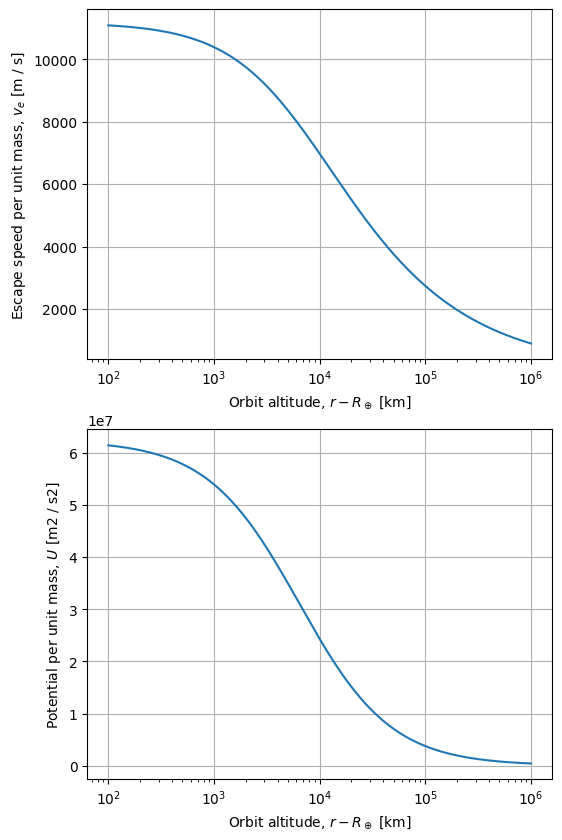

In [28]:
fig, ax = plt.subplots(figsize=(6, 10), nrows=2, ncols=1)
ax[0].plot(altitudes, escape_speed)
ax[0].grid()
ax[0].set_xscale('log')
ax[0].set_xlabel(f'Orbit altitude, $r - R_\\oplus$ [{altitudes.unit}]')
ax[0].set_ylabel(f'Escape speed per unit mass, $v_e$ [{escape_speed.unit}]')

ax[1].plot(altitudes, potential)
ax[1].grid()
ax[1].set_xscale('log')
ax[1].set_xlabel(f'Orbit altitude, $r - R_\\oplus$ [{altitudes.unit}]')
ax[1].set_ylabel(f'Potential per unit mass, $U$ [{potential.unit}]')

Excellent, this is the shape we expected. As our $R$ value moves away from the center of Earth, the gravitational potential decreases and so too does the escape velocity.

### Compute velocity for circular orbits at each altitude
We can use the potential energy definition to find the tangential velocity that would result in a perfectly circular orbit, too.

By definition for a circular orbit at radius $r$, we want the tangental component of velocity ($v$) to equal the radial component of velocity . Assuming a spherical homogeneous body, _i.e._ constant potential $U$ at a given radius $r$, $v$ relative to the central body will be constant. We can use the formula for centripetal motion with the acceleration from gravity as the centripetal acceleration.

In short, we need to go sideways exactly as fast as we fall at any given point for the orbit to be circular. Remember we want speed per unit mass.

$$g = \frac{G M_\oplus}{r} = \frac{v_{circular}^2}{r}$$
$$v_{circular} = \sqrt{\frac{G M_\oplus}{r}}$$


In [29]:
circular_velocity = np.sqrt(potential)
circular_velocity

<Quantity [7844.13467138, 7844.07887809, 7844.02303459, ...,  629.92055304,
            629.63234204,  629.34426124] m / s>

Text(0, 0.5, 'Velocity per unit mass [m / s]')

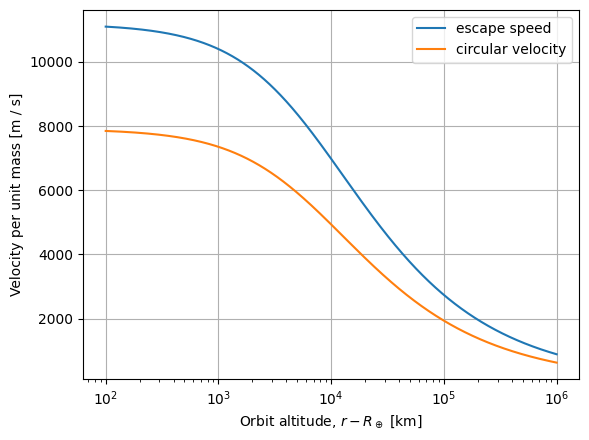

In [30]:
plt.plot(altitudes, escape_speed)
plt.plot(altitudes, circular_velocity.to(escape_speed.unit))
plt.legend([f"escape speed", "circular velocity"])
plt.grid()
plt.xscale('log')
plt.xlabel(f'Orbit altitude, $r - R_\\oplus$ [{altitudes.unit}]')
plt.ylabel(f'Velocity per unit mass [{escape_speed.unit}]')

A few sanity checks:
* Do circular velocity and escape speed decrease as orbit altitude leaves the gravity well? **Yes.**
* Is circular velocity for a $500 \text{km}$ altitude around $ 7 \text{km}/\text{s}$? **Yes.**

### Total time dilation
Let's put it all together to recreate the plot we saw on Wikipedia.

Difference in proper times for each unit $t_c$ is
$$
\frac{\Delta t_{diff}}{\Delta t_c} = (\gamma_{U,self} - \gamma_{U,other}) + (\gamma_{K,self} - \gamma_{K,other})
$$
$$
\Delta t_{diff} = \Delta t_c \Bigg[ \sqrt{1-\frac{2GM}{c^2 r_{self}}} - \sqrt{1-\frac{2GM}{c^2 r_{other}}} \Bigg] + \Delta t_c \Bigg[ \sqrt{1-\frac{(v_{self} - v_{frame})^2}{c^2}} - \sqrt{1-\frac{(v_{other} - v_{frame})^2}{c^2}} \Bigg]
$$
where:
$$v_e = \sqrt{\frac{2GM_\oplus}{r}}, \quad v_{circular} = \sqrt{\frac{G M_\oplus}{r}}$$

In [31]:
c_squared = np.power(c, 2)

def relativistic_factor(velocity):
    v_squared = velocity ** 2
    percent_c = (v_squared / c_squared)
    return (1 - percent_c) ** 0.5

def gravitational_time_dilation(potential):
    escape_speed = (2 * potential) ** 0.5
    return relativistic_factor(escape_speed)

def kinematic_time_dilation(velocity):
    return relativistic_factor(velocity)


In [32]:
potential = GM_earth / r
circular_speed = np.sqrt(potential)

grav_dilation = gravitational_time_dilation(potential)
kinematic_dilation = kinematic_time_dilation(circular_speed)
total_dilation = grav_dilation + kinematic_dilation

In [33]:
def plot_dilation(altitudes,
                  grav_dilation,
                  kinematic_dilation,
                  total_dilation=None,
                  yunit='[s/s]'):
    plt.figure(figsize=(12, 8))
    labels = ["gravitational, $\\gamma_U$", "kinematic, $\\gamma_K$"]
    plt.plot(altitudes, grav_dilation, color='blue')
    plt.plot(altitudes, kinematic_dilation, color='red')
    if total_dilation is not None:
        plt.plot(altitudes, total_dilation, color='magenta')
        labels.append("$\\gamma_U + \\gamma_K$")
    plt.legend(labels)
    plt.xscale('log')
    plt.xlim([altitudes[0].value, altitudes[-1].value])
    plt.xlabel(f'Orbit altitude, $r - R_\\oplus$ [{altitudes.unit}]')
    plt.ylabel(f"Dilation from coordinate time {yunit}")
    plt.grid()
    plt.grid(which='minor', color='#DDDDDD', linewidth=0.5)
    plt.axhline(linewidth=1, color="k")

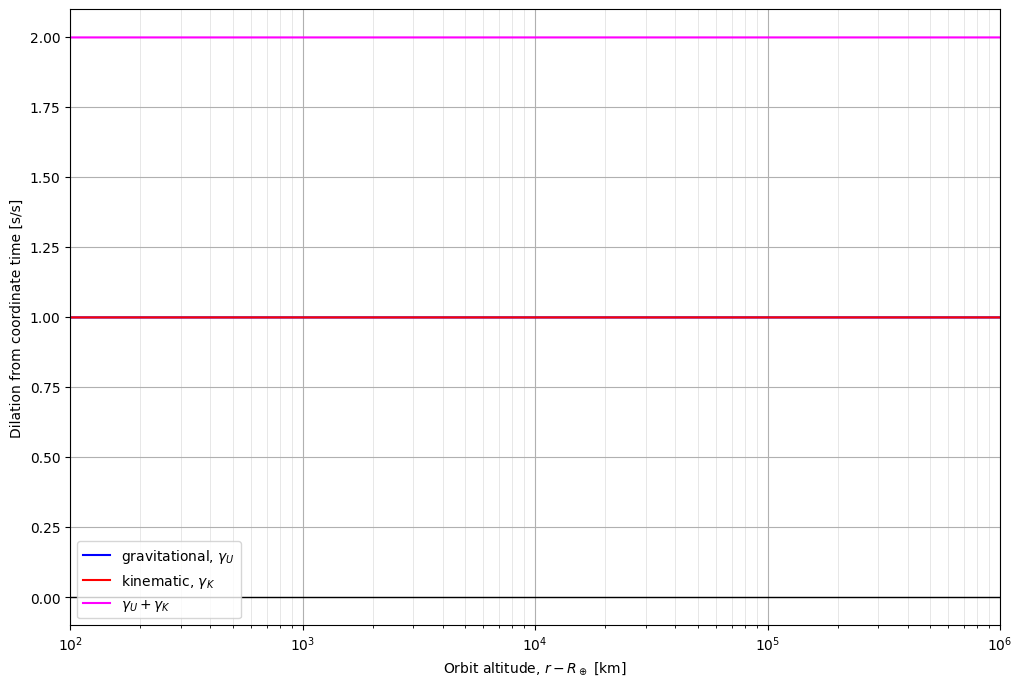

In [34]:
plot_dilation(
    altitudes, 
    grav_dilation, 
    kinematic_dilation, 
    total_dilation,
    )

Yikes that doesn't look right. Perhaps this is a precision issue. Let's inspect some of the numbers in our equation and the results.

In [35]:
from IPython.display import display, Latex
i = 0
quantities = [
    ('$U$', potential[i]),
    ('$v$', circular_speed[i].to(u.m / u.s)),
    ('$v_e$', escape_speed[i].to(u.m / u.s))
]
display( Latex(f"r = {r[i]:latex}"))
for quantity in quantities:
    display(Latex(f"{quantity[0]} = {quantity[1]:latex}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

This looks alright. Let's see what happens when we square velocities and divide by $c^2$...

In [36]:
np.power(escape_speed, 2) / c_squared

<Quantity [1.36923714e-09, 1.36921767e-09, 1.36919817e-09, ...,
           8.82998869e-12, 8.82191047e-12, 8.81383960e-12]>

In [37]:
1 - np.power(escape_speed, 2) / c_squared

<Quantity [1., 1., 1., ..., 1., 1., 1.]>

Aha, Python is interpreting numbers $n \leq 10^{-12}$ as $\approx 0$. In most cases this is probably fine, but not for us! Let's fix that.

### Dealing with precision
![xkcd for everything](https://www.explainxkcd.com/wiki/images/8/88/coordinate_precision.png)

There are a few ways to deal with precision here.
1. **Use a larger data type.** This might work, but it's not actually solving our problem. Most of the precision in a larger data type would be wasted holding zeroes.
2. **Split value and order of magnitude and re-scale it later.** This is a simple fix that keeps the values we care about comfortably within precision of normal data types, since it's no different than switching between meters and nanometers, for example. This can be tricky unless we are super careful about keeping track of values after we split them.
3. **Scale the units first.** This ends up being the same as (2) but with an added benefit of letting our code libraries keep track of the units. A major weakness is that we don't know for sure how the data is being represented under the hood.

Let's try option 2.

If we make a custom class and define what should happen for math operations, we won't even have to change our functions from before.

In [38]:
from dataclasses import dataclass
from astropy.units import Quantity

@dataclass
class PreciseQuantity:
    scalar: float
    order: int
    unit: u.Unit

    def __add__(self, other):
        if not isinstance(other, PreciseQuantity):
            other = to_precise(other)
        other_scaled = match_order(other, self)
        scalar = self.scalar + other_scaled.scalar
        order = self.order
        unit = self.unit
        return PreciseQuantity(scalar, order, unit)

    def __radd__(self, other):
        return other.__add__(self)

    def __sub__(self, other):
        if not isinstance(other, PreciseQuantity):
            other = to_precise(other)
        other_scaled = match_order(other, self)
        scalar = self.scalar - other_scaled.scalar
        order = self.order
        unit = self.unit
        return PreciseQuantity(scalar, order, unit)

    def __rsub__(self, other):
        neg_other = other * -1
        return self.__add__(neg_other)

    def __mul__(self, other):
        if not isinstance(other, PreciseQuantity):
            other = to_precise(other)
        scalar = self.scalar * other.scalar
        order = self.order + other.order
        unit = self.unit * other.unit
        return PreciseQuantity(scalar, order, unit).scale()

    def __rmul__(self, other):
        return self.__mul__(other)

    def __truediv__(self, other):
        if not isinstance(other, PreciseQuantity):
            other = to_precise(other)
        if other.scalar == 0:
            raise ValueError(f'Failed to divide {self} by {other}: cannot divide by zero')
        scalar = self.scalar / other.scalar
        order = self.order - other.order
        unit = self.unit / other.unit
        return PreciseQuantity(scalar, order, unit).scale()

    def __pow__(self, p):
        if self.scalar < 0 and abs(p) < 1:
            raise ValueError(f'Failed to raise {self} to the power {p}: Result is imaginary')
        scalar = np.power(self.scalar, p)
        order = self.order * p
        unit = self.unit ** p
        return PreciseQuantity(scalar, order, unit).scale()

    def scale(self):
        scalar_order = get_order(self.scalar)
        # reduce scalar
        scalar = self.scalar * expand_order(-scalar_order)
        # update the order by the amount the scalar was reduced
        order = self.order + scalar_order
        unit = self.unit
        return PreciseQuantity(scalar, order, unit)

def expand_order(o: int):
    return np.power(10, float(o))

def match_order(q:PreciseQuantity, q_ref:PreciseQuantity) -> PreciseQuantity:
    o_diff = q_ref.order - q.order
    scalar = q.scalar * expand_order(o_diff)
    order = q.order + o_diff
    unit = q.unit
    return PreciseQuantity(scalar, order, unit)

def get_order(num: float) -> int:
    if not isinstance(num, float) and not isinstance(num, int):
        raise TypeError(f'Can only get order for scalars, but {num=} has type {type(num)}')
    if num == 0:
        return 0
    else:
        return np.floor(np.log10(abs(num)))

def to_precise(q: Quantity | float) -> PreciseQuantity:
    if isinstance(q, PreciseQuantity):
        return q
    elif isinstance(q, Quantity):
        value = q.value
        unit = q.unit
    else:
        value = q
        unit = u.Unit('')

    order = get_order(value)
    scalar = value / expand_order(order)
    return PreciseQuantity(scalar, order, unit)


def from_precise(pq: PreciseQuantity | list):
    if isinstance(pq, list):
        return [q.scalar * expand_order(q.order) * q.unit for q in pq]
    else:
        return pq.scalar * expand_order(pq.order) * pq.unit

Sanity check! Does this class behave how we expect?

In [39]:
print(f"{'lists:':>11s}  {[Quantity(1), Quantity(2)]} == {from_precise([to_precise(q) for q in [1, 2]])}")
print(f"{'convert:':>11s} {c:e} -> {to_precise(c)=}")
print(f"{'restore:':>11s} {c:e} == {from_precise(to_precise(c))=}")
print(f"{'add:':>11s} {c+c:e} == {to_precise(c) + to_precise(c)}")
print(f"{'subtract:':>11s} {c-c:e} == {to_precise(c) - to_precise(c)}")
print(f"{'multiply:':>11s} {c*c:e} == {to_precise(c) * to_precise(c)}")
print(f"{'divide:':>11s} {c/c:e} == {to_precise(c) / to_precise(c)}")
print(f"{'root:':>11s} {np.sqrt(c):e} == {to_precise(c) ** 0.5}")
print(f"{'power:':>11s} {np.power(np.sqrt(9),2):e} == {(to_precise(9)**0.5)**2}")
print(f"{'large add:':>11s} {1e3 + 1e-3:e} == {to_precise(1e3) + to_precise(1e-3)}")
try:
    val = to_precise(-1) ** 0.5
    print(f"{'imaginary:':>11s}  sqrt(-1) == {val}")
except Exception as e:
    print(f"{'imaginary:':>11s}  sqrt(-1) == {e}")

     lists:  [<Quantity 1.>, <Quantity 2.>] == [<Quantity 1.>, <Quantity 2.>]
   convert: 2.997925e+08 m / s -> to_precise(c)=PreciseQuantity(scalar=2.99792458, order=8.0, unit=Unit("m / s"))
   restore: 2.997925e+08 m / s == from_precise(to_precise(c))=<Quantity 2.99792458e+08 m / s>
       add: 5.995849e+08 m / s == PreciseQuantity(scalar=5.99584916, order=8.0, unit=Unit("m / s"))
  subtract: 0.000000e+00 m / s == PreciseQuantity(scalar=0.0, order=8.0, unit=Unit("m / s"))
  multiply: 8.987552e+16 m2 / s2 == PreciseQuantity(scalar=8.987551787368176, order=16.0, unit=Unit("m2 / s2"))
    divide: 1.000000e+00 == PreciseQuantity(scalar=1.0, order=0.0, unit=Unit(dimensionless))
      root: 1.731452e+04 m(1/2) / s(1/2) == PreciseQuantity(scalar=1.7314515817660048, order=4.0, unit=Unit("m(1/2) / s(1/2)"))
     power: 9.000000e+00 == PreciseQuantity(scalar=9.0, order=0.0, unit=Unit(dimensionless))
 large add: 1.000001e+03 == PreciseQuantity(scalar=1000001.0, order=3.0, unit=Unit(dimensionles

Great, now let's apply our functions using our new data type.

In [40]:
precise_potential = [to_precise(p) for p in potential]
precise_circular_speed = [to_precise(v) for v in circular_speed]

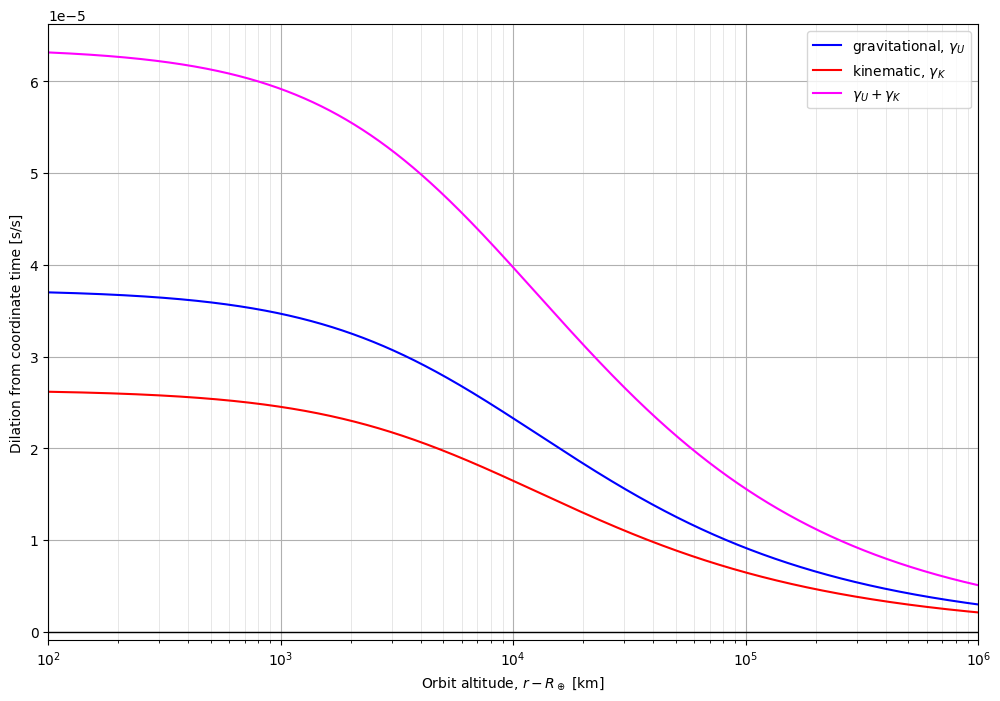

In [41]:
precise_grav_dilation = [gravitational_time_dilation(p) for p in precise_potential]
precise_kinematic_dilation = [kinematic_time_dilation(v) for v in precise_circular_speed]
precise_total_dilation = [to_precise(n) for n in np.sum([
    from_precise(precise_grav_dilation),
    from_precise(precise_kinematic_dilation),
    ], axis=0
)]

plot_dilation(
    altitudes,
    from_precise(precise_grav_dilation),
    from_precise(precise_kinematic_dilation),
    from_precise(precise_total_dilation),
)

Before we continue, let's do one more sanity check by doing a few of the calculations ourselves.

$$\frac{\Delta t_{diff}}{\Delta t_c} = \gamma_{U} + \gamma_{K}$$
$$
\frac{\Delta t_{diff}}{\Delta t_c} = \sqrt{1-\frac{v_e^2}{c^2}} + \sqrt{1-\frac{v_{circular}^2}{c^2}}
$$
where:
$$v_e = \sqrt{\frac{2GM_\oplus}{r}}, \quad v_{circular} = \sqrt{\frac{G M_\oplus}{r}}$$

In [42]:
indices = [0, int(len(r)/2), -1]
precise_c_squared = to_precise(c_squared)
for index in indices:
    r_i = r[index]
    v_e_squared = to_precise(2 * GM_earth / r_i)
    escape_pct_c = (v_e_squared / precise_c_squared)
    gamma_u = (1 - escape_pct_c) ** 0.5
    
    v_squared = to_precise(GM_earth / r_i)
    v_pct_c = (v_squared / precise_c_squared)
    gamma_k = (1 - v_pct_c) ** 0.5
    
    by_hand = from_precise(gamma_u + gamma_k)
    script = from_precise(precise_total_dilation[index])
    print(f'{r_i=}\n{script=} {by_hand=}\n')

r_i=<Quantity 6478100. m>
script=<Quantity 6.31684214e-05> by_hand=<Quantity 0.00029866>

r_i=<Quantity 16382706.69150364 m>
script=<Quantity 3.9721992e-05> by_hand=<Quantity 3.9721992e-05>

r_i=<Quantity 1.0063781e+09 m>
script=<Quantity 5.06807763e-06> by_hand=<Quantity 5.06807763e-06>



### Dilation relative to Earth surface

Kinematic dilation also looks flipped from what we expect. This is because the figure from Wikipedia is measuring the dilation from Earth's surface but we're displaying dilation with respect to coordinate time for the gravitational dilation.

We want to arrange the equation such that
* $\Delta t_{drift} > 0$ means $other$'s clock will be **faster** than $self$'s clock, and
* $\Delta t_{drift} < 0$ means $other$'s clock will be **slower** than $self$'s clock

$$\Delta t_{drift} = 1 - \Big[ (\gamma_{U,self} - \gamma_{U,other}) + (\gamma_{K,self} - \gamma_{K,other}) \Big]$$

$$
\Delta t_{drift} = 1 - \Bigg[ \Bigg( \sqrt{1-\frac{2GM}{c^2 r_{\oplus}}} - \sqrt{1-\frac{2GM}{c^2 r_{satellite}}} \Bigg) - \Bigg(\sqrt{1-\frac{v_{surface}^2}{c^2}} - \sqrt{1-\frac{v_{satellite}^2}{c^2}} \Bigg) \Bigg]
$$
where:
$$v_{surface} = \omega_{\oplus} R_{\oplus}$$
$$v_{satellite} = v_{circular} = \sqrt{\frac{G M_\oplus}{r}}$$

Text(0, 0.5, 'Time difference [s per Earth second]')

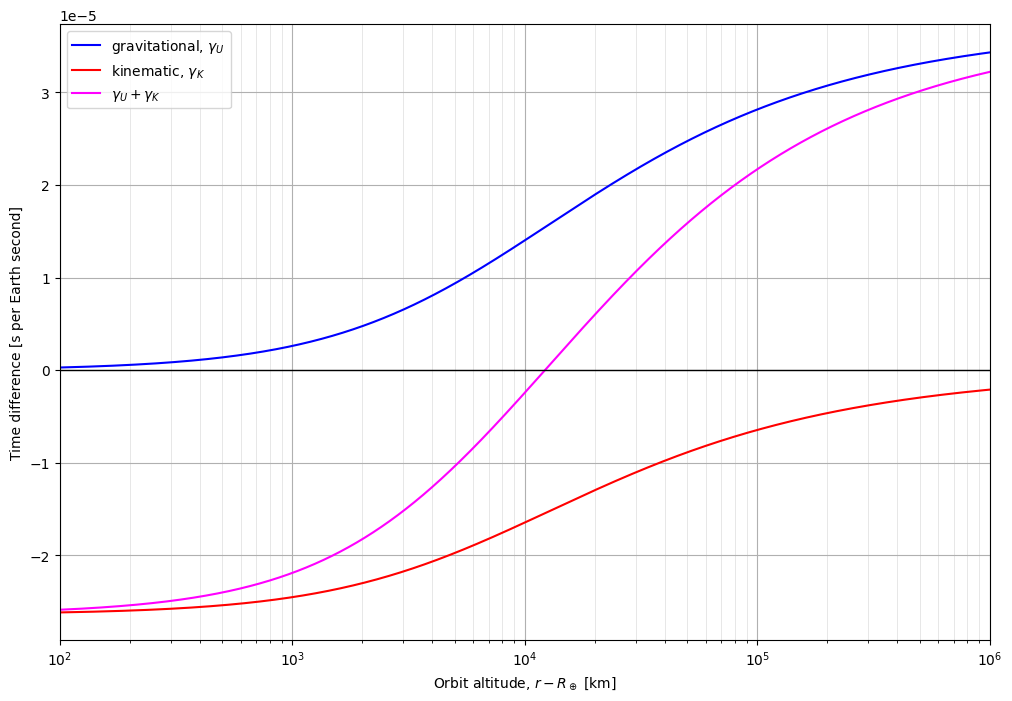

In [43]:
ref_potential = GM_earth / earth_radius.to(u.m)
precise_ref_potential = to_precise(ref_potential)
ref_grav_dilation = from_precise(gravitational_time_dilation(precise_ref_potential))

ref_speed = w_earth * earth_radius.to(u.m)
precise_ref_speed = to_precise(ref_speed)
ref_kine_dilation = 0 #from_precise(kinematic_time_dilation(precise_ref_speed))

rel_grav_dilation = [
    ref_grav_dilation - from_precise(gamma_u) for gamma_u in precise_grav_dilation
]
rel_kinematic_dilation = [
    ref_kine_dilation - from_precise(gamma_k) for gamma_k in precise_kinematic_dilation
]

rel_total_dilation = np.sum([
    rel_grav_dilation,
    rel_kinematic_dilation,
    ], axis=0
)

plot_dilation(
    altitudes,
    rel_grav_dilation,
    rel_kinematic_dilation,
    rel_total_dilation,
)
plt.ylabel(f"Time difference [s per Earth second]")

The shape looks right, but the y-axis doesn't match our reference (the pink line below). First of all, we have to convert $s/s$ to $\mu s/day$.

In [44]:
def to_us_per_day(sec_per_sec):
    us_per_sec = 1e6
    sec_per_day = 86_400
    return sec_per_sec * us_per_sec * sec_per_day

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
E:\Temp\ipykernel_29312\721535034.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel(f"Time difference [$\mu$s per Earth day]")


Text(0, 0.5, 'Time difference [$\\mu$s per Earth day]')

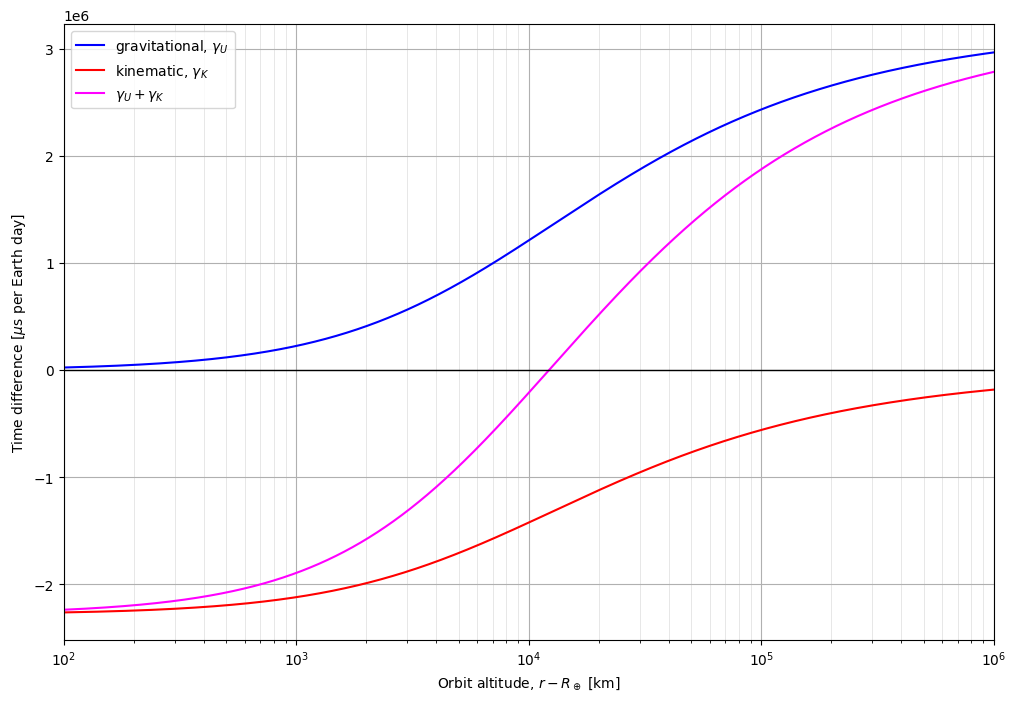

In [45]:
scaled_grav_dilation = [to_us_per_day(gamma) for gamma in rel_grav_dilation]
scaled_kinematic_dilation = [to_us_per_day(gamma) for gamma in rel_kinematic_dilation]
scaled_total_dilation = np.sum([
    scaled_grav_dilation,
    scaled_kinematic_dilation,
    ], axis=0
)
plot_dilation(
    altitudes,
    scaled_grav_dilation,
    scaled_kinematic_dilation,
    scaled_total_dilation,
)
plt.ylabel(f"Time difference [$\mu$s per Earth day]")

![time dilation plot](./Time_Dilation_vs_Orbital_Height.png)

(0.0, 50000.0)

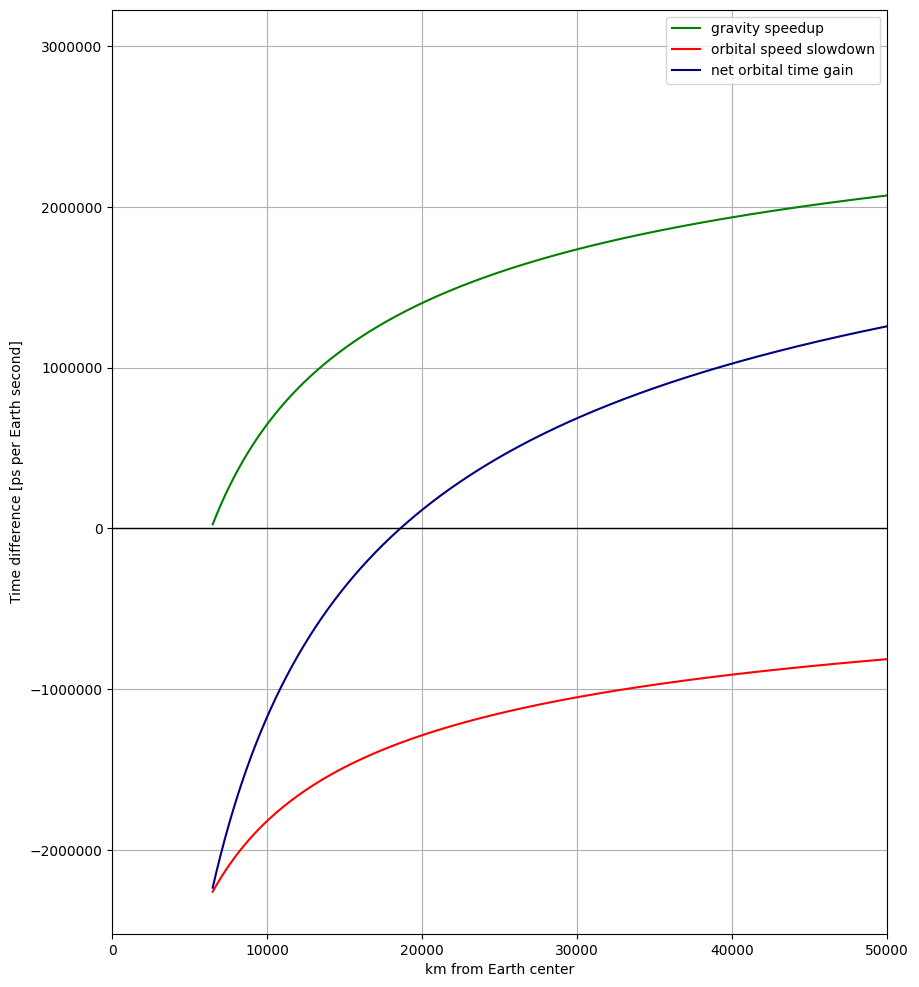

In [46]:
plt.figure(figsize=(10,12))
labels = ["gravity speedup", "orbital speed slowdown"]
plt.plot(r.to(u.km), scaled_grav_dilation, color='green')
plt.plot(r.to(u.km), scaled_kinematic_dilation, color='red')
if total_dilation is not None:
    plt.plot(r.to(u.km), scaled_total_dilation, color='navy')
    labels.append("net orbital time gain")
plt.legend(labels)
plt.xscale('linear')
plt.xlabel(f'{r.to(u.km).unit} from Earth center')
plt.ylabel(f"Time difference [ps per Earth second]")
plt.grid()
plt.grid(which='minor', color='#DDDDDD', linewidth=0.5)
plt.axhline(linewidth=1, color="k")
plt.ticklabel_format(style='plain')
plt.xlim([0, 50_000])

![](./Orbit_times.svg.png)

Hmm...this look right in terms of the numbers but wrong in terms of order of magnitude...